<a href="https://colab.research.google.com/github/antoinemarchal/GASKAP/blob/master/GASKAP_absorption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GASKAP absorption/emission regularized optimization

##Model

###Gaussian
\begin{equation}
  G(v_z, \theta_n) = a_n exp   \left( - \frac{\big(v_z - \mu_n\big)^2}{2 \sigma_n^2} \right)
\end{equation}

\begin{equation}
  \tilde \tau\big(v_z, \theta_{\tau}\big) = \sum_{n=1}^{N} G\big(v_z, \theta_{\tau,n}\big)
\end{equation}

###Cost function
\begin{equation}
  Q_{\tau}(\theta_{\tau}) = \frac{1}{2} ||L_{\tau}(v_z, \theta)||_{\Sigma_{\tau}}^2 
\end{equation}

###Spectral regularization
\begin{equation}
  R(\theta^{\rm Tb}, \theta^{\tau}) =  \frac{1}{2} \, \sum_{n=1}^N \lambda_{\mu} \|(\mu_n/\mu^{abs}_n) - 1\|_2^2 + \lambda_{\sigma} \|(\sigma_n/\sigma^{abs}_n) - 1\|_2^2
\end{equation}

###Full cost function
\begin{equation}
  J(\theta) = \lambda_{Tb} Q_{Tb}(\theta) + \lambda_{\tau} Q_{\tau}(\theta) + R(\theta^{\rm Tb}, \theta^{\tau})
\end{equation}

##Installation

In [1]:
!rm -rf GASKAP
!git clone https://github.com/antoinemarchal/GASKAP
import os
os.chdir('GASKAP')
!pip install .

Cloning into 'GASKAP'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 86 (delta 39), reused 40 (delta 12), pack-reused 0
Unpacking objects: 100% (86/86), done.
Processing /content/GASKAP
  Created wheel for GASKAP: filename=GASKAP-0.1.0-cp36-none-any.whl size=10733 sha256=bb6560da80e6d662dd4faec8b677e5b5e0556fa4db6eaa862caa6ed2ad2894c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-e9sbhu2w/wheels/e1/f3/a5/4a96430ea8eb9561e77a6328e612df8c0f7341122e28c6fa5b
Successfully built GASKAP


##Getting started with the GASKAP python package
###Import libraries

In [0]:
import numpy as np
from astropy.io import fits
import astropy.table as pytabs
import matplotlib.pyplot as plt

from GASKAP.absorption import lbfgs_abs

###Run lbfgs_abs minimization

In [0]:
#Open 21-Sponge data
path = 'data/'
name = '3C225A'

cat = fits.getdata(path+"sponge.fits")
data_s = pytabs.Table(cat)
idx_absline = np.where(data_s["NAMES"] == name)[0][0]
v = data_s[idx_absline]["VEL"]
Tb = data_s[idx_absline]["TB"]
tau = data_s[idx_absline]["TAU"]

#Channel spacing
dv = np.diff(v)[0]

#hdr
hdr=fits.Header()
hdr["CDELT3"] = dv
hdr["CRPIX3"] = 0
hdr["CRVAL3"] = v[0]*1.e3

#parameters                                                                                                                                                                                                                                                              
amp_fact_init = 2./3.
sig_init = 2.
iprint_init = -1
iprint = -1
maxiter_init = 15000
maxiter = 15000

n_gauss = 18             #@param {type:"slider", min:3, max:24, step:3} 
lambda_Tb = 1            #@param {type:"slider", min:1, max:100, step:10}
lambda_tau = 1          #@param {type:"slider", min:1, max:100, step:10}
lambda_mu = 1           #@param {type:"slider", min:0, max:100, step:10}
lambda_sig = 1          #@param {type:"slider", min:0, max:100, step:10}
lb_amp = 0.
ub_amp = np.max(Tb)
lb_mu = 1
ub_mu = len(tau)
lb_sig= 1
ub_sig = 30

core = lbfgs_abs(Tb=Tb, tau=tau, hdr=hdr)

result = core.run(n_gauss=n_gauss,
                  lb_amp=lb_amp,
                  ub_amp=ub_amp,
                  lb_mu=lb_mu,
                  ub_mu=ub_mu,
                  lb_sig=lb_sig,
                  ub_sig=ub_sig,
                  lambda_Tb=lambda_Tb,
                  lambda_tau=lambda_tau,
                  lambda_mu=lambda_mu,
                  lambda_sig=lambda_sig,
                  amp_fact_init=amp_fact_init,
                  sig_init=sig_init,
                  maxiter=maxiter,
                  maxiter_init=maxiter_init,
                  iprint=iprint,
                  iprint_init=iprint_init)


###Print Objective function

In [4]:
print("J =",result[1])

J = 0.059893052560604836


###Compute model

In [0]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
vfield_Tb = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,0])
vfield_tau = core.mean2vel(hdr["CRVAL3"]*1.e-3, hdr["CDELT3"], hdr["CRPIX3"], 
                            params[1::3,1])

model_cube = core.model(params, cube, n_gauss)

###Plot figures

####Gaussian parameters

Text(0, 0.5, '$\\sigma$ [km s$^{-1}$]')

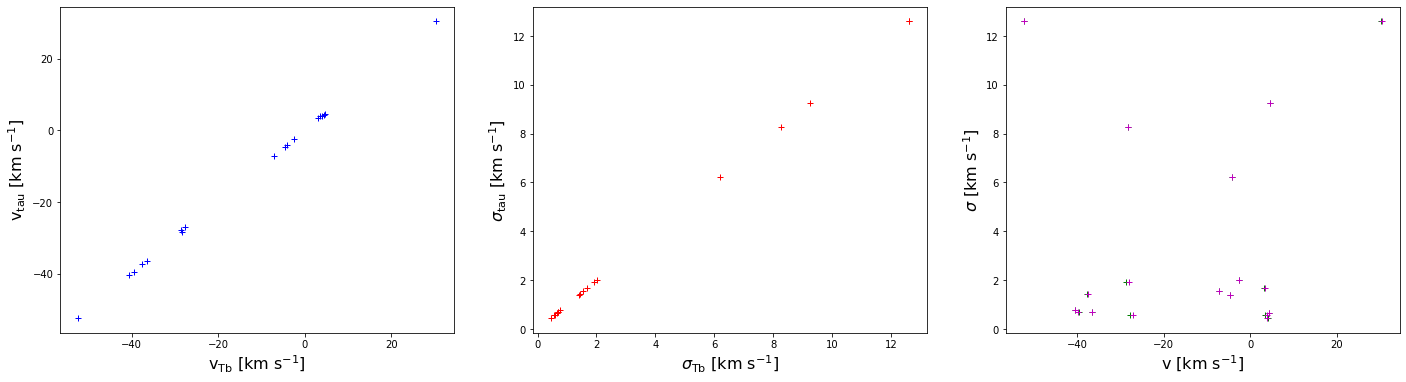

In [12]:
plt.figure(figsize=(24,6))

plt.subplot(1,3,1)
plt.plot(vfield_Tb, vfield_tau, "+b")
plt.xlabel(r"v$_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"v$_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

plt.subplot(1,3,2)
plt.plot(params[:,0][2::3]*dv, params[:,1][2::3]*dv, "+r")
plt.xlabel(r"$\sigma_{\rm Tb}$ [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma_{\rm tau}$ [km s$^{-1}$]", fontsize=16)

plt.subplot(1,3,3)
plt.plot(vfield_Tb, params[:,0][2::3]*dv, "+g")
plt.plot(vfield_tau, params[:,1][2::3]*dv, "+m")
plt.xlabel(r"v [km s$^{-1}$]", fontsize=16)
plt.ylabel(r"$\sigma$ [km s$^{-1}$]", fontsize=16)



Text(0, 0.5, 'a$_{\\rm tau}$')

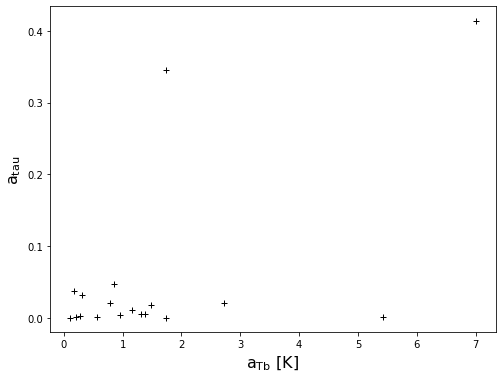

In [15]:
plt.figure(figsize=(8,6))
plt.subplot(1,1,1)
plt.plot(params[:,0][0::3], params[:,1][0::3], "+k")
plt.xlabel(r"a$_{\rm Tb}$ [K]", fontsize=16)
plt.ylabel(r"a$_{\rm tau}$", fontsize=16)

####Plot emission vs absorption spectrum

Text(0.5, 0, 'v [km s$^{-1}$]')

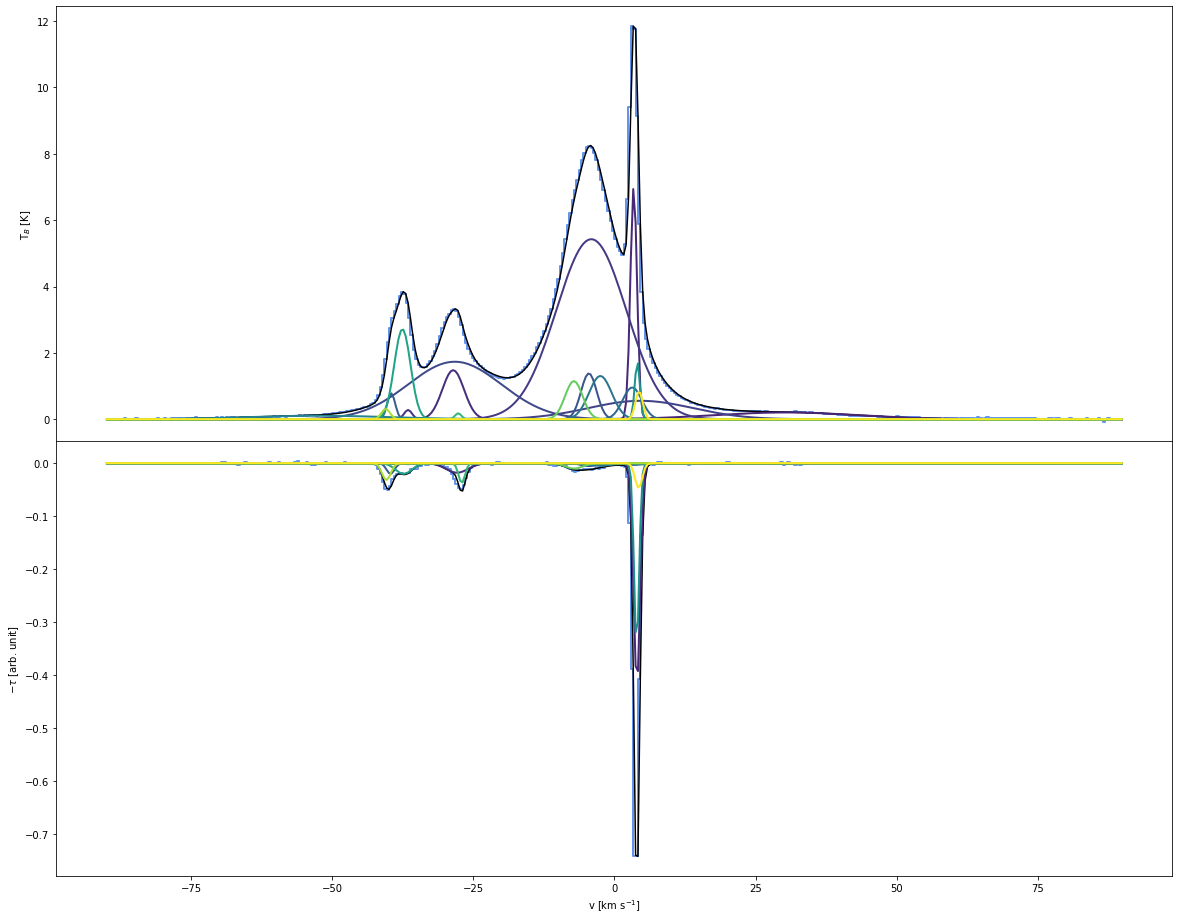

In [9]:
#Compute model                                                                                                                                                                                                                                                                
cube = np.moveaxis(np.array([Tb,tau]),0,1)
params = np.reshape(result[0], (3*n_gauss, cube.shape[1]))
model_cube = core.model(params, cube, n_gauss)

#Plot                                                                                                                                                                                                                                                                         
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,16))
fig.subplots_adjust(hspace=0.)
x = np.arange(cube.shape[0])
ax1.step(v, cube[:,0], color='cornflowerblue', linewidth=2.)
ax1.plot(v, model_cube[:,0], color='k')
ax2.step(v, -cube[:,1], color='cornflowerblue', linewidth=2.)
ax2.plot(v, -model_cube[:,1], color='k')
for i in np.arange(cube.shape[1]):
    for k in np.arange(n_gauss):
        line = core.gaussian(x, params[0+(k*3),i], params[1+(k*3),i], 
                              params[2+(k*3),i])
        if i == 1:
            ax2.plot(v, -line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)
        else:
            ax1.plot(v, line, color=plt.cm.viridis(pvalues[k]), linewidth=2.)

ax1.set_ylabel(r'T$_{B}$ [K]')
ax2.set_ylabel(r'$- \tau$ [arb. unit]')
ax2.set_xlabel(r'v [km s$^{-1}$]')


####Plot residuals

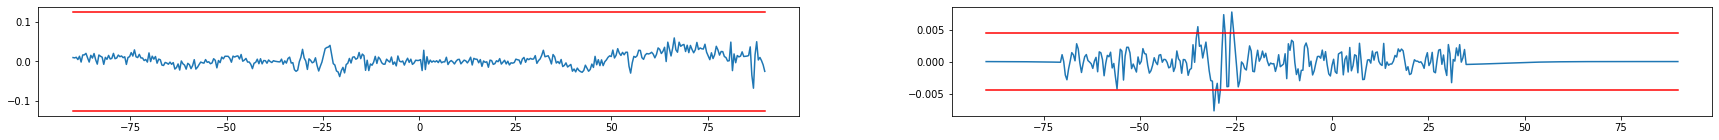

In [10]:
plt.figure(figsize=(30,2))
vmin=np.min(v); vmax=np.max(v)
rms_Tb = np.std(Tb[50:100]); rms_tau=np.std(tau[50:100])
plt.subplot(1,2,1)
plt.plot(v, Tb - model_cube[:,0])
plt.plot([vmin,vmax], [-3.*rms_Tb,-3.*rms_Tb], color="r")
plt.plot([vmin,vmax], [3.*rms_Tb,3.*rms_Tb], color="r")
plt.subplot(1,2,2)
plt.plot(v, tau - model_cube[:,1])
plt.plot([vmin,vmax], [-3.*rms_tau,-3.*rms_tau], color="r")
plt.plot([vmin,vmax], [3.*rms_tau,3.*rms_tau], color="r")
